# Разведочный анализ каротажных данных

   Необходимо провести EDA открытого датасета Volve, содержащего реальные данные, собранные при разработке и эксплуатации одноименного месторождения.<br>
План работы для проведения EDA:<br>
● Пройти по всем папкам в архиве и ознакомиться с их содержимым<br>
● Собрать Pandas DataFrame<br>
● Оценить полноту данных через долю отсутствующих значений по каждому каналу сбора информации и скважине<br>
● Предложить мероприятия по работе с пропущенными значениями.

In [1]:
# Libraries for data loading
import lasio
from dlisio import dlis
import pandas as pd
import numpy as np
import os

# Libraries for data visualization:
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

Для анализа будем использовать каротажные данные по каждой скважине.<br>Нас интересуют только файлы в формате .las и .dlis из подпапок 02.LWD_EWL (данные, полученные во время бурения)  и 04.COMPOSITE (данные ГИС)

![Array scheme](pictures/tree.JPG)

Создадим массив для структуризации файлов и соберем в ячейки массива списки доступных файлов.<br>
Схематически наполнение массива показано на рисунке:

![Array scheme](pictures/array_1.JPG)

In [2]:
folders=['LWD_EWL','COMPOSITE']
file_types=['.las','.dlis']

#пустой массив
files_array=np.empty((2,2),dtype=list)

In [3]:
#Проходим циклом по ячейкам массива
for i in range(len(folders)):
    for j in range (len(file_types)):
        files_array[i][j]=list()
        for root, dirs, files in os.walk('Well_logs_pr_WELL_slice'):
            for file in files:
                #если в названии директории есть 'LWD_EWL'/'COMPOSITE' и если название файла заканчивается на .las/.dlis,
                #то в ячейку массиве добавляем к списку путь к этому файлу
                if (folders[i] in root) and (file.lower().endswith(file_types[j])):
                    files_array[i][j].append(os.path.join(root,file))

Массив files_array наполнен списками "сырых" файлов, необходимых для работы.<br>
Создадим второй массив по аналогии с предыдущим, но наполним его ячейки таблицами DataFrame, составленными из соответствующих файлов.

![Array scheme](pictures/array_2.JPG)

In [4]:
#пустой массив
df_array=np.empty((2,2),dtype=list)

In [5]:
#наполняем первый столбец массива (только данные из las-файлов)
for i in range(len(folders)):
    df_list=[]
    for las_file in files_array[i][0]:   #проходим циклом по каждому файлу из имеющегося списка в ячейке
        las = lasio.read(las_file, ignore_header_errors=True)
        lasdf = las.df().reset_index()
        #добавляем новые признаки
        lasdf['WELL'] = las.well.WELL.value
        lasdf['Channel']='LAS_'+str(folders[i])
        df_list.append(lasdf)
    #трансформируем получившиеся списки датафреймов в единый датафрейм
    if len(df_list)==1:
        df_array[i][0]=df_list[0]
    else:
        df_array[i][0]=pd.concat(df_list)

In [6]:
#аналогично наполняем второй столбец массива (данные из dlis-файлов) с помощью методов модуля dlisio
for i in range(len(folders)):
    df_list=[]
    for dlis_file in files_array[i][1]:
        file,*tail=dlis.load(dlis_file)
        for frame in file.frames:
            for channel in frame.channels:
                if channel.name == frame.index:
                    depth_units = channel.units
        dlisdf=pd.DataFrame(frame.curves())
        origin, *origin_tail = file.origins
        dlisdf['WELL']=origin.well_name
        dlisdf['Channel']='DLIS_'+str(folders[i])
        df_list.append(dlisdf)
    df_array[i][1]=pd.concat(df_list)

Теперь в каждой ячейке массива df_array находится соответствующий DataFrame.<br>Назначим имена таблицам и приступим к изучению их структуры.

In [23]:
LWD_las=df_array[0][0]
GIS_las=df_array[1][0]
LWD_dlis=df_array[0][1]
GIS_dlis=df_array[1][1]

In [8]:
display(LWD_las.head())
display(GIS_las.head())
display(LWD_dlis.head())
display(GIS_dlis.head())

,DEPT,ROP5,HKLD,SWOB,TQA,CRPM_RT,RPM,STICK_RT,TRPM_RT,TFLO,ATMP,APRS_ARC,ECD_ARC,SPPA,SHKRSK_RT,SHK2_RT,WELL,Channel,TVDE,ARC_GR_RT,SHK_ADN_RT,PDSHKRSK,TIME,DATE,BPOS,BVEL,ECD_ARC_RT,DRHO_DH_ADN_RT,RHOB_DH_ADN_RT,PD_GRAV_BHC,INCL_CONT_RT,PDINCL,SRPM_RT,CRPM,TRPM,BONB,DHAP,DHAT,ECD,GRMA_ECO_RT,SHKL_DH_ECO_RT,SHKPK_RT,ARC_GR_UNC_RT,GRMA_BHC_RT,UCAV_DH_ECO_RT,SHK_ISONIC_RT,GRM1,ECD_MWD,ATMP_MWD,APRS_MWD,DWOB_RT,DTOR_RT
0,0.61,42.6446,128.3909,7.6949,2.6579,NaN,180.4407,NaN,NaN,4519.5712,NaN,NaN,NaN,4356.5155,0.0,NaN,15/9-F-12,LAS_LWD_EWL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.76,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.0,-6.8948,0.4041,NaN,NaN,NaN,15/9-F-12,LAS_LWD_EWL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.91,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.0,-6.8948,0.4422,NaN,NaN,NaN,15/9-F-12,LAS_LWD_EWL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.0,-6.8948,0.4917,NaN,NaN,NaN,15/9-F-12,LAS_LWD_EWL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.0,-6.8948,0.5494,NaN,NaN,NaN,15/9-F-12,LAS_LWD_EWL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,DEPT,AC,CALI,DEN,GR,NEU,RDEP,RMED,WELL,Channel
0,102.1568,NaN,NaN,NaN,5.3274,NaN,NaN,NaN,15/9-19,LAS_COMPOSITE
1,102.3092,NaN,NaN,NaN,5.8235,NaN,NaN,NaN,15/9-19,LAS_COMPOSITE
2,102.4616,NaN,NaN,NaN,6.5228,NaN,NaN,NaN,15/9-19,LAS_COMPOSITE
3,102.6140,NaN,NaN,NaN,7.2285,NaN,NaN,NaN,15/9-19,LAS_COMPOSITE
4,102.7664,NaN,NaN,NaN,9.5020,NaN,NaN,NaN,15/9-19,LAS_COMPOSITE


,FRAMENO,TDEP,ROPAVG,WOBAVG,FLOWIN,SURFRPM,TORQUEAV,PUMPAVG,TCDM,GRSIM,RACESHM,RPCESHM,RAAESHM,RPAESHM,RAAESLM,RPCESLM,RACESLM,RPAESLM,RACELM,RPCELM,RAAELM,RPAELM,RACEHM,RPCEHM,RAAEHM,RPAEHM,RPTHM,SSRPMAXM,SSRPMINM,SSRPMAVM,V2SEVXYM,V2SEVZM,V2AVGXYM,V2MAXXYM,V2MINXYM,V2AVGZM2,V2MAXZM2,V2MINZM2,APRESM,BPRESM,ACTECDM,TVD,GR1AFM,GR2AFM,GRAFM,WELL,Channel,DTCO,6TIM,ROP5_RM,BS,TNRA,TNPH,TAB_NEU,TNRA_UNC,TNPH_UNC,ROLB,ROBB,DRHB,PEB,RPM_ADN,TAB_DEN,IDRO,IDDR,IDPE,SHK2_ADN,TTEM_ADN,SHK1_ADN,ANGA,TEMP_ARC,SHK1_ARC,AGTM,GR_ARC_RAW,GR_ARC_CAL,GR_ARC_FILT,GR_ARC,DEVI,TAB_ARC_RES,A16H,A22H,A28H,A34H,A40H,P16H,P22H,P28H,P34H,P40H,A16L,A22L,A28L,A34L,A40L,P16L,P22L,P28L,P34L,P40L,P16B,P22B,P28B,P34B,P40B,A16B,A22B,A28B,A34B,A40B,A16H_COND,A22H_COND,A28H_COND,A34H_COND,A40H_COND,P16H_COND,P22H_COND,P28H_COND,P34H_COND,P40H_COND,A16L_COND,A22L_COND,A28L_COND,A34L_COND,A40L_COND,P16L_COND,P22L_COND,P28L_COND,P34L_COND,P40L_COND,A16B_COND,A22B_COND,A28B_COND,A34B_COND,A40B_COND,P16B_COND,P22B_COND,P28B_COND,P34B_COND,P40B_COND,A112,A212,A122,A222,A132,A232,A142,A242,A152,A252,A114,A214,A124,A224,A134,A234,A144,A244,A154,A254,P112,P212,P122,P222,P132,P232,P142,P242,P152,P252,P114,P214,P124,P224,P134,P234,P144,P244,P154,P254,APRS_ARC,ATMP,ECD_ARC,DTRP,DTTP,1TIM,TICK_DEN,TICK_NEU,TICK_ARC_GR,TICK_ARC_RES,TICK_GR,TICK_DHAP,ROLU,ROLR,ROLL,RHOL,ROSU,ROSR,ROSB,ROSL,RHOS,ROBU,ROBR,ROBL,RHOB,DRHU,DRHR,DRHL,DRHO,PEU,PER,PEL,PEF,UU,UR,UB,UL,U,DSOU,DSOL,DSOR,DSOB,DCHO,DCVE,DCAV,CRPM,QC_RHOB,QC_PEF,TTEM,BS_ARC,QC_RXO,QC_FRT,QC_RES,EFR2,UCAV,UCVE,UCHO,QC_UCAL,TAB_UCAL,DHAP,DHAT,ECD,TAB_DHAP,VIB_X,BCAV,BCVE,BCHO,HAZI,TAB_GR,RGRA,GRMA_FILT,GRMA,RGRU,GRMU_FILT,RGRL,GRML_FILT,RGRB,GRMB_FILT,RGRR,GRMR_FILT,QC_GR,GX_CAL,GX_TEMP,INCL_CONT,NER1,NER2,FAR1,FAR2,BPHI,BPHI_UNC,DBPHI,QC_BPHI,QC_TNPH,MONT,TICK_UCAL,SIFA,SIFB,SIFL,SIFU,SIFR,TICK_SPC,UCAL1,UCAL2,UCAL3,UCAL4,UCAL5,UCAL6,UCAL7,UCAL8,EFR1,NER1B,NER2B,NER1L,NER2L,NER1U,NER2U,NER1R,NER2R,FAR1B,FAR2B,FAR1L,FAR2L,FAR1U,FAR2U,FAR1R,FAR2R,TNPB,TNPL,TNPU,TNPR,BPHB,BPHL,BPHU,BPHR,TNPB_UNC,TNPL_UNC,TNPU_UNC,TNPR_UNC,BPHB_UNC,BPHL_UNC,BPHU_UNC,BPHR_UNC,DBPHB,DBPHL,DBPHU,DBPHR,RFSA,RFSB,RFSL,RFSU,RFSR,QC_SIGM,QC_SPEC,WANH,WCLA,WCAR,WQFM,WPYR,WSID,WCOA,WEVA,CHY_WALK2,CSI_WALK2,CCA_WALK2,CCHL_WALK2,CFE_WALK2,CSUU_WALK2,CGD_WALK2,CTI_WALK2,CNC_WALK2,CK_WALK2,DWSI_WALK2,DWCA_WALK2,DWFE_WALK2,DWSU_WALK2,DWTI_WALK2,DWGD_WALK2,DWAL_WALK2,ASAL_WALK2,FY2W_WALK2,DXFE_WALK2,TAB_SPC,CSUL_WALK2,ROP5,GRM1,APRS_MWD,ATMP_MWD,ECD_MWD
0,1,183.300003,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-935.133484,-999.25,-999.25,-999.25,15/9-F-11,DLIS_LWD_EWL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

,FRAMENO,DEPTH,GR,RDEP,RMED,ROP,BS,WELL,Channel,GRAFM,GRSIM,RACEHM,RACELM,ROPAVG,RPCEHM,RPCELM,RPCESHM,RPTHM,TCDM,WOBAVG,CALI,DEN,DENC,PEF,NEU,AC,A28H,A34H,A40H,ATMP,CRPM,DCAV,DCHO,DCVE,DRHB,DRHL,DRHO,DRHR,DRHU,DTCO,DTRP,DTTP,GR_ARC_FILT,GRMA,P16H,P16L,P22H,P22L,P28H,P28L,P34H,P34L,P40H,P40L,PEB,PEL,PER,PEU,RHOB,ROBB,ROBL,ROBR,ROBU,ROP5_RM,SHK1_ARC,TAB_ARC_RES,TNPH,UCAV,UCHO,UCVE,DEPT,DWAL_WALK2,DWCA_WALK2,DWFE_WALK2,DWGD_WALK2,DWSI_WALK2,DWSU_WALK2,DWTI_WALK2,DXFE_WALK2,RHGE,SIGE,WCAR,WCLA,WPYR,WQFM,WSID,A16H,A22H,ATMP_MWD,BPHI,GR_ARC,GRM1,ROP5
0,1,183300.0,-999.25,-999.25,-999.25,-999.25,-999.25,15/9-F-11,DLIS_COMPOSITE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,183400.0,-999.25,-999.25,-999.25,-999.25,-999.25,15/9-F-11,DLIS_COMPOSITE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,183500.0,-999.25,-999.25,-999.25,-999.25,-999.25,15/9-F-11,DLIS_COMPOSITE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,183600.0,-999.25,-999.25,-999.25,-999.25,-999.25,15/9-F-11,DLIS_COMPOSITE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,183700.0,-999.25,-999.25,-999.25,-999.25,-999.25,15/9-F-11,DLIS_COMPOSITE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Так как все таблицы имеют разную структуру, было решено не объединять их в один датафрейм, а анализировать по отдельности.

## Анализ пропущенных значений

(выводы представлены в конце раздела)

 Необходимо оценить полноту данных через долю отсутствующих значений по каждому каналу сбора информации и скважине.<br>Для этого будем группировать таблицы по названиям скважин, в качестве агрегирующей функции будем использовать долю пропусков.

In [9]:
#функция для вычисления доли пропусков в %
def nulls_ratio(s):
    return (1 - s.count()/s.size)*100

**Данные LWD las**

In [10]:
LWD_las.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 591396 entries, 0 to 16589
Data columns (total 52 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   DEPT            506978 non-null  float64
 1   ROP5            588881 non-null  float64
 2   HKLD            568789 non-null  float64
 3   SWOB            589122 non-null  float64
 4   TQA             588608 non-null  float64
 5   CRPM_RT         282869 non-null  float64
 6   RPM             578202 non-null  float64
 7   STICK_RT        346706 non-null  float64
 8   TRPM_RT         539136 non-null  float64
 9   TFLO            588265 non-null  float64
 10  ATMP            367587 non-null  float64
 11  APRS_ARC        308547 non-null  float64
 12  ECD_ARC         367587 non-null  float64
 13  SPPA            440390 non-null  float64
 14  SHKRSK_RT       516488 non-null  float64
 15  SHK2_RT         293101 non-null  float64
 16  WELL            591396 non-null  object 
 17  Channel    

In [11]:
#вывод доли пропусков с группировкой по скважинам
LWD_las_null_ratio=LWD_las.groupby('WELL').agg(nulls_ratio)
LWD_las_null_ratio

,DEPT,ROP5,HKLD,SWOB,TQA,CRPM_RT,RPM,STICK_RT,TRPM_RT,TFLO,ATMP,APRS_ARC,ECD_ARC,SPPA,SHKRSK_RT,SHK2_RT,Channel,TVDE,ARC_GR_RT,SHK_ADN_RT,PDSHKRSK,TIME,DATE,BPOS,BVEL,ECD_ARC_RT,DRHO_DH_ADN_RT,RHOB_DH_ADN_RT,PD_GRAV_BHC,INCL_CONT_RT,PDINCL,SRPM_RT,CRPM,TRPM,BONB,DHAP,DHAT,ECD,GRMA_ECO_RT,SHKL_DH_ECO_RT,SHKPK_RT,ARC_GR_UNC_RT,GRMA_BHC_RT,UCAV_DH_ECO_RT,SHK_ISONIC_RT,GRM1,ECD_MWD,ATMP_MWD,APRS_MWD,DWOB_RT,DTOR_RT
WELL,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
15/9-F-12,55.865264,1.259347,1.230230,1.230230,1.230230,41.995897,8.456753,36.692476,11.799351,1.230891,38.274105,38.274105,38.274105,1.351995,4.579445,42.047515,0.0,100.000000,69.803454,69.803454,100.000000,6.711667,6.711667,6.711667,6.711667,69.803454,69.803454,69.803454,100.000000,92.773476,92.773476,92.773476,92.773476,92.773476,92.773476,92.773476,92.773476,92.773476,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.00000,100.000000
15/9-F-15 A,0.000000,0.065233,0.008859,0.008859,0.014496,8.607554,0.008859,8.605943,8.594669,0.079729,56.023999,56.023999,56.023999,0.126440,8.593863,100.000000,0.0,100.000000,100.000000,100.000000,100.000000,14.987517,14.987517,14.987517,14.987517,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,44.127406,44.127406,44.127406,97.756302,50.333414,8.593863,56.081984,52.508657,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.00000,100.000000
15/9-F-15B,0.000000,0.018102,9.580486,0.009051,0.009051,100.000000,0.009051,6.693216,6.693216,0.009051,100.000000,100.000000,100.000000,0.009051,6.688691,100.000000,0.0,100.000000,100.000000,100.000000,100.000000,9.580486,9.580486,9.580486,9.580486,100.000000,100.000000,100.000000,100.000000,9.580486,100.000000,100.000000,100.000000,100.000000,100.000000,0.294158,0.294158,0.294158,95.157714,100.000000,100.000000,100.000000,9.580486,9.580486,100.000000,100.000000,100.000000,100.000000,100.000000,100.00000,100.000000
15/9-F-5,0.000000,0.038225,5.935963,0.000000,0.508998,46.781543,0.000000,11.357898,11.345827,0.770538,39.772259,39.772259,39.772259,0.770538,45.061412,46.763437,0.0,100.000000,43.986078,100.000000,46.766454,16.679241,16.679241,16.679241,16.679241,100.000000,100.000000,100.000000,93.451429,66.291457,100.000000,100.000000,100.000000,100.000000,100.000000,60.608987,60.608987,60.608987,97.185422,64.584402,46.776514,100.000000,66.291457,100.000000,64.789611,100.000000,100.000000,100.000000,100.000000,46.77249,46.771484
15/9-F5,0.000000,0.444974,0.380991,0.380991,0.380991,16.147045,0.380991,16.181945,9.676012,0.380991,100.000000,100.000000,100.000000,0.380991,9.710912,100.000000,0.0,100.000000,100.000000,100.000000,100.000000,23.569102,23.569102,23.569102,23.569102,100.000000,100.000000,100.000000,100.000000,23.569102,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,9.710912,100.000000,100.000000,100.000000,100.000000,9.684737,9.798162,9.676012,9.705095,100.00000,100.000000
15_9_F-12,0.000000,0.209706,7.856501,0.169138,0.169762,100.000000,0.169138,100.000000,4.788921,0.170386,0.242785,37.091197,0.242785,92.312637,4.808268,4.754594,0.0,92.312637,2.325494,4.946200,6.497778,7.856501,7.856501,7.856501,7.856501,100.000000,100.000000,100.000000,7.856501,7.856501,7.856501,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.00000,100.000000


Для наглядности составим тепловую карту пропусков

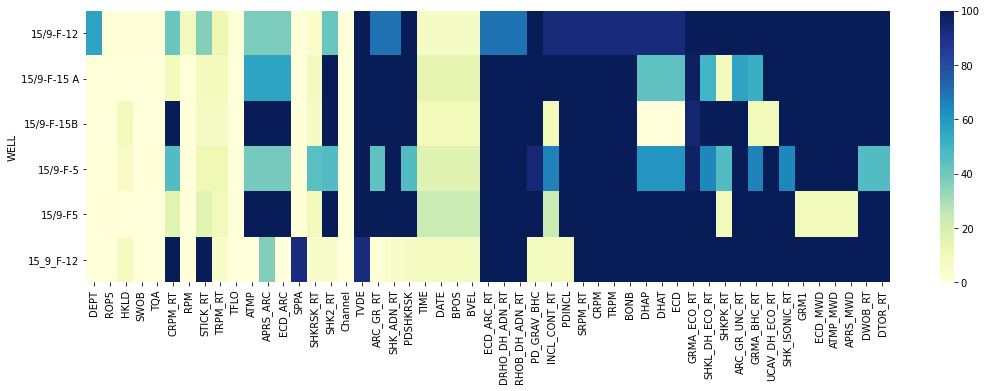

In [12]:
fig,axes=plt.subplots(nrows=1,ncols=1,figsize=(18,5))
sns.heatmap(LWD_las_null_ratio, cmap='YlGnBu',ax=axes);

**Данные GIS las**

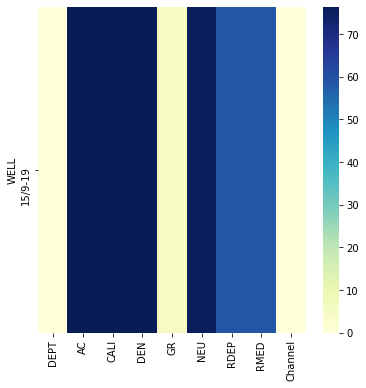

In [27]:
#аналогично предыдущему блоку
GIS_las_null_ratio=GIS_las.groupby('WELL').agg(nulls_ratio)
fig,axes=plt.subplots(nrows=1,ncols=1,figsize=(6,6))
sns.heatmap(GIS_las_null_ratio, cmap='YlGnBu',ax=axes);

Как видно из графика, las-данные ГИС имеются только по одной скважине, релевантные данные содержатся в канале GR (менее 20% пропусков), то есть ГИС даёт информацию о гамма по глубине. Так же имеются данные RDEP, RMED с заполнением около 40% - предположительно требовалась запись этих данных с меньшей частотой (количество точек на единицу времени), чем для гаммы. В остальных каналах доля пропусков более 90%, однако следует рассмотреть распределение пропусков во времени - возможно, запись велась только в определенные интервалы времени.  Каналы можно использовать далее для интерпретации данных по скважине 15/9-19, объединив с другими датафреймами по ключу Depth. 

**Данные LWD dlis**

In [24]:
LWD_dlis.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406302 entries, 0 to 8036
Columns: 366 entries, FRAMENO to ECD_MWD
dtypes: float32(362), float64(1), int32(1), object(2)
memory usage: 583.1+ MB


В датафрейме 366 столбцов, для удобства визуального анализа разобьем график на 4 части - не более 100 столбцов в одном графике.<br> Строим аналогично тепловую карту пропусков по каждой скважине.

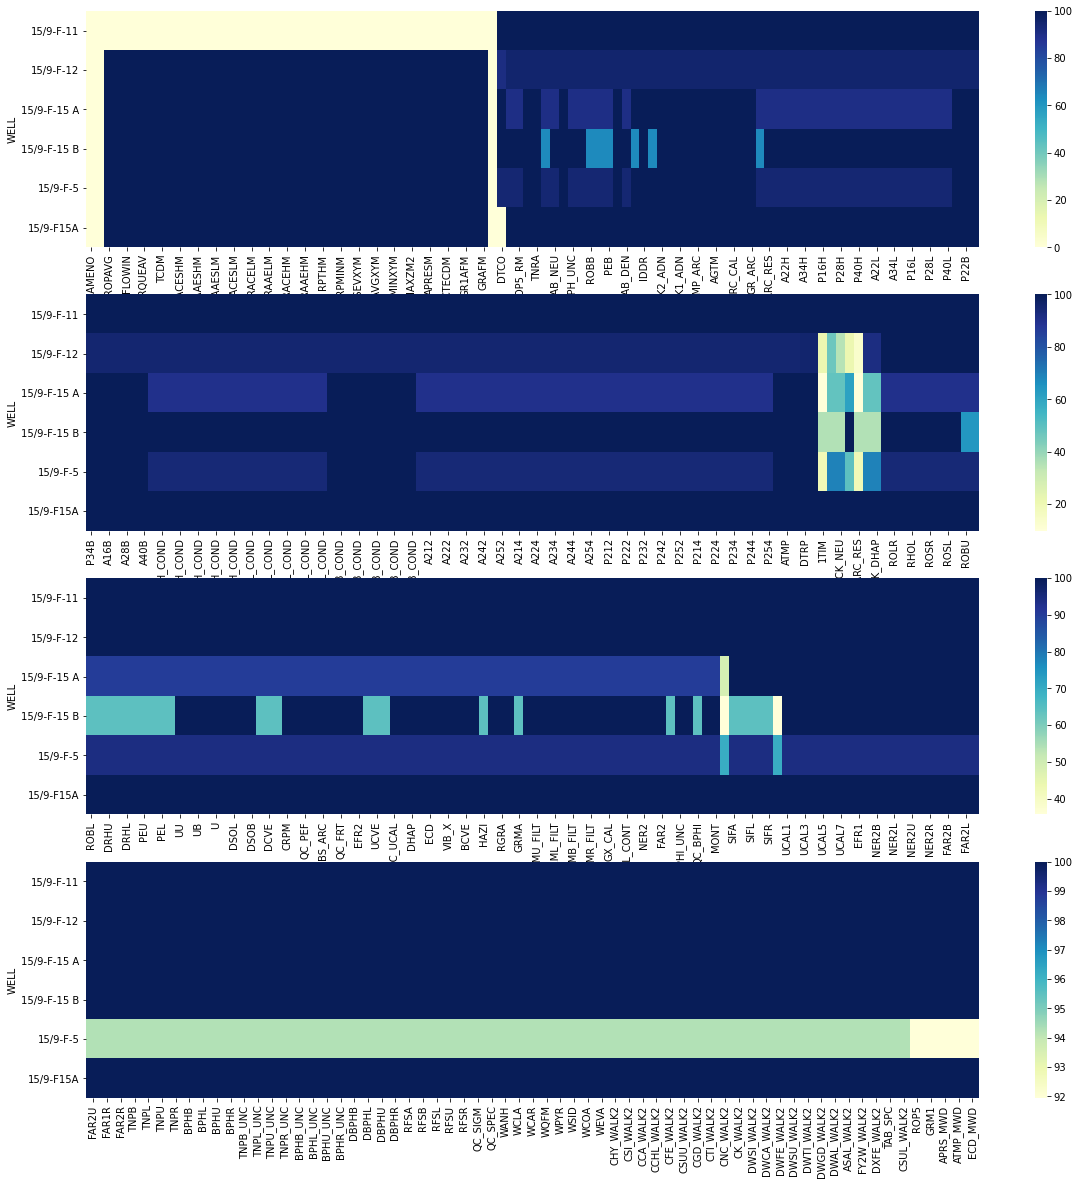

In [25]:
LWD_dlis_null_ratio=LWD_dlis.groupby('WELL').agg(nulls_ratio)
fig,axes=plt.subplots(nrows=4,ncols=1,figsize=(20,20))
sns.heatmap(LWD_dlis_null_ratio[LWD_dlis_null_ratio.columns[:100]], cmap='YlGnBu',ax=axes[0]);
sns.heatmap(LWD_dlis_null_ratio[LWD_dlis_null_ratio.columns[100:200]], cmap='YlGnBu',ax=axes[1]);
sns.heatmap(LWD_dlis_null_ratio[LWD_dlis_null_ratio.columns[200:300]], cmap='YlGnBu',ax=axes[2]);
sns.heatmap(LWD_dlis_null_ratio[LWD_dlis_null_ratio.columns[300:]], cmap='YlGnBu',ax=axes[3]);

**Данные GIS dlis**

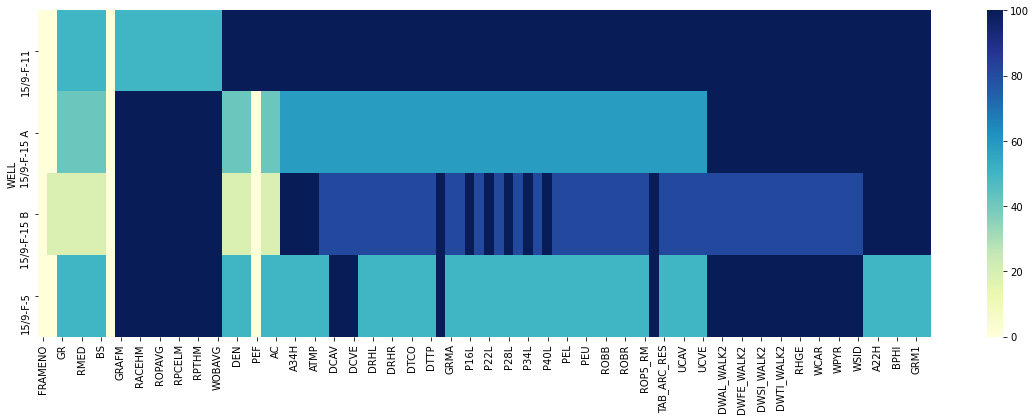

In [26]:
GIS_dlis_null_ratio=GIS_dlis.groupby('WELL').agg(nulls_ratio)
fig,axes=plt.subplots(nrows=1,ncols=1,figsize=(20,6))
sns.heatmap(GIS_dlis_null_ratio, cmap='YlGnBu',ax=axes);

### Выводы:
**По всем скважинам имеются каналы данных с пропущенными данными. Для оценки возможноости работать с этими каналами необходимо провести более детальный анализ, а именно: по каждой скважине построить тепловые карты с осями "время записи (или глубина)"-"каналы данных" и рассмотреть, как распределены пропуски по времени (глубине). Если распределенеие равномерное, скорее всего, эти данные требовалось записывать с меньшей частотой. Также пропуски могут быть обусловлены тем, что данные требовалось записывать только в определенные интервалы времени. В таких случаях канал следует оставить и использовать далее для интерпретации данных каротажа,  а пропущенные данные можно заменить расчетными значениями - вычислить интерполированием соседних точек.**

## Каротажные кривые для скважины 15_9-19


Исходя из построенных графиков, по скважине 15_9-19 у нас имеется только las-файл ГИС.
Для построения кривых будем использовать датафрейм этих данных - GIS_las

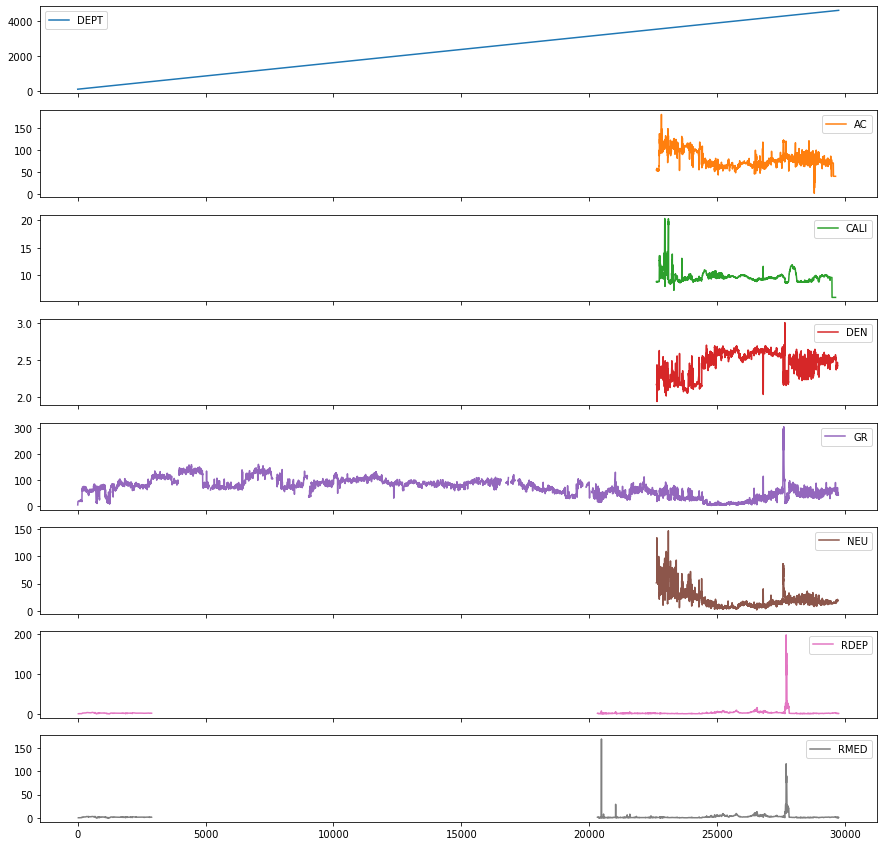

In [44]:
GIS_las.plot(subplots=True, figsize=(15, 15));